# Moving Least Squares Demo

This notebook will demonstrate the features of the Entropic Trajectories framework with respect to 
estimating derivatives of 1d and 2d functions.  We begin by importing the required packages

## Vanilla Least Squares

We will first examine the simpler problem of a Vanilla least squares approach.

In [79]:
%matplotlib notebook
import numpy as np
from ipywidgets import *
import matplotlib.pyplot as plt
# we'll need Matrix, UGrid, and Approximator
from etraj.etraj import Vector, Matrix, UGrid, Approximator, ScalarField
import etraj.etraj as et

Let's generate a one-dimensional unstructured grid over the domain $[-\pi,\pi]$.

In [80]:
# create a random one-dimensional grid
# between -pi and pi.
N = 1000
x = np.random.uniform(-np.pi,np.pi,N)

g = UGrid(x)

Let's use the grid we just made to generate function values for the function,

\begin{equation}
f(x) = \cos\left(\frac{3}{2}x\right).
\end{equation}

In [81]:
# generate the function values for f(x) = cos(x)
f = np.cos(1.5*x)

The result is plotted below.

<IPython.core.display.Javascript object>


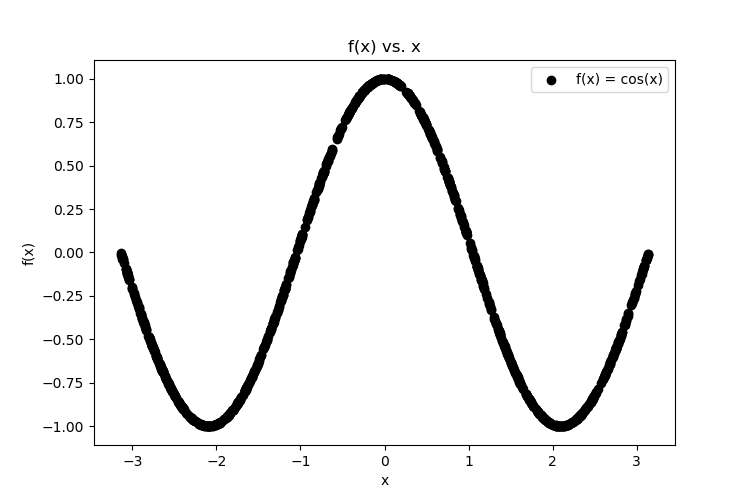

In [82]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 1')
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

Next, consider that we choose a random point in the grid.  

In [83]:
# consider a random point in our grid
i_rand = np.random.randint(len(x))
x_rand, f_rand = x[i_rand], f[i_rand]

print("Random index: ",i_rand)
print("Random point: ",x_rand)
print("Random f(x):  ",f_rand)

Random index:  802
Random point:  -1.8685799398556393
Random f(x):   -0.9431798448694326


<IPython.core.display.Javascript object>


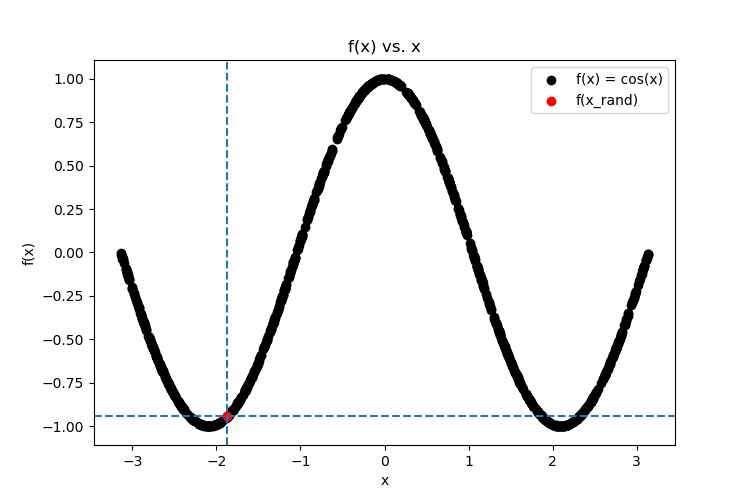

In [84]:
# lets plot that point
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 2')
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

To compute the derivative at the point $x_{\mathrm{rand}}$, we will need to select a neighborhood around $x_{\mathrm{rand}}$ to use in the approximation.  Setting the number of nearest neighbors to use as $k = 5$, we can query the grid to find them,

In [85]:
# select a number of nearest neighbors to use for the point
k = 10
g.query_neighbors(k)
# grab the nearest neighbors to the point x_rand
neighbors = g.get_neighbors(i_rand)

print("indices of the %s nearest neighbors to the point %s:" % (k,i_rand))
print(neighbors)

indices of the 10 nearest neighbors to the point 802:
[802, 818, 269, 728, 626, 128, 354, 336, 891, 882]


Next we'll want to grab the $x$ and $f(x)$ values for the indices corresponding to the nearest neighbors

In [86]:
# grab the x and f values for those neighbors
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]

print("x values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(x_neighbors)
print("f(x) values for the %s nearest neighbors to the point %s:" % (k,x_rand))
print(f_neighbors)

x values for the 10 nearest neighbors to the point -1.8685799398556393:
[-1.8685799398556393, -1.8627841995518728, -1.8754719816762486, -1.876516200566603, -1.8774342667341977, -1.8509190484146876, -1.850808059837169, -1.8494597846950958, -1.889715006956646, -1.8470482403803286]
f(x) values for the 10 nearest neighbors to the point -1.8685799398556393:
[-0.9431798448694326, -0.9402555030600548, -0.9465645419042059, -0.9470685440702232, -0.9475097380477251, -0.9340473237090987, -0.9339878515318625, -0.9332633242546133, -0.9532383714642714, -0.9319579066938058]


Now we can plot the $k$ nearest neighbors.

<IPython.core.display.Javascript object>


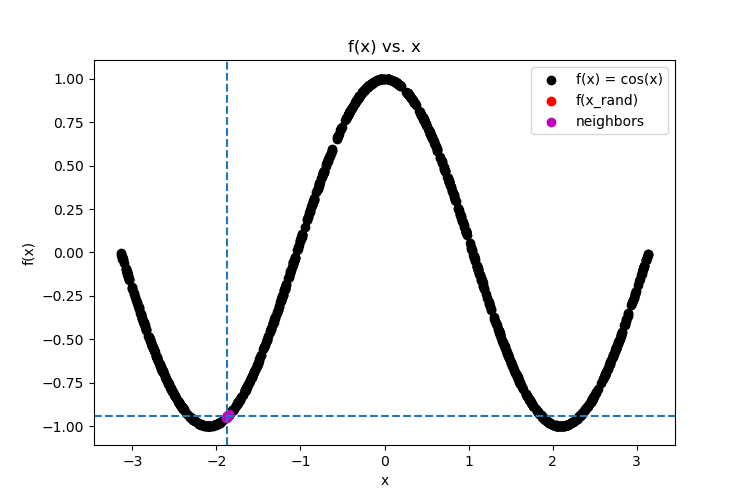

In [87]:
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 3')
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

We can implement the moving least squares algorithm by hand by calling various methods from within the approximator class.  First, we will need to constructor an instance of an approximator.

In [88]:
# Construct an instance of an approximator
app = Approximator()

Using the default constructor for approximator generates the following default parameters, which we can expose by using the print() function from python,

In [89]:
print(app)


Approximator type: Vanilla least squares
Least squares driver type: xGELS
Approximator parameters - k = 3
                          n = 3


Vanilla least squares consists of creating a Vandermonde-type matrix $B$ in which each row consists of the differences of order $n$, $(\Delta x_i^k)^n = (x^k - x_i)^n$, from the Taylor expansion of the function $f(x^k)$ expanded around the point $x_i$. 

In [90]:
# construct the B matrix for first order in the Taylor expansion
# up to order n = 5
n = 5
b_matrix = app.construct_taylor_matrix(g,neighbors,i_rand,n)

print(b_matrix)

dim: (10x6), type: double&, name: 'B'
[  1.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00   0.000e+00
   1.000e+00   5.796e-03   3.359e-05   1.947e-07   1.128e-09   6.540e-12
   1.000e+00  -6.892e-03   4.750e-05  -3.274e-07   2.256e-09  -1.555e-11
      ...         ...         ...         ...         ...         ...
   1.000e+00   1.912e-02   3.656e-04   6.990e-06   1.336e-07   2.555e-09
   1.000e+00  -2.114e-02   4.467e-04  -9.441e-06   1.995e-07  -4.217e-09
   1.000e+00   2.153e-02   4.636e-04   9.982e-06   2.149e-07   4.628e-09  ]


From here, the least squares problem can be solved by constructing the vector of function values,

\begin{equation}
\vec{f} = (f(x_1),\dots,f(x_{k})).
\end{equation}

In [91]:
# create the vector of function values for each point
v = Vector("f_vec",f_neighbors)

print(v)

dim: 10, type: double&, name: 'f_vec'
[ -9.432e-01  -9.403e-01  -9.466e-01   ...   -9.333e-01  -9.532e-01  -9.320e-01  ]


Now we simply solve for the coefficients $\vec{c}$ from,

\begin{equation}
B\vec{c} = \vec{f},
\end{equation}

using the function **DGELS** from the ET framework,

In [92]:
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
f_app = et.dgels(b_matrix,v)

print(f_app)

dim: 6, type: double&, name: 'min_u||B*u - f_vec|'
[ -9.432e-01   4.984e-01   1.061e+00  -1.869e-01  -1.989e-01   2.124e-02  ]


We can find the tangent vector to $f(x)$ from the first and second entries of $\vec{c}$, which are the coefficients of the Taylor expansion of $f(x)$ around $x_i$,

In [151]:
# the y-intercept of the tangent vector is
f_0 = -f_app[1]*x_rand + f_rand
# while the slope is
f_1 = f_app[1]

print("The tangent vector of f(x) at %s is:" % x_rand)
print("<x, %.2f*x + %.2f>" % (f_1,f_0))

The tangent vector of f(x) at 0.8768471739282546 is:
<x, -1.45*x + 1.53>


Let's visualize the tangent line

<IPython.core.display.Javascript object>


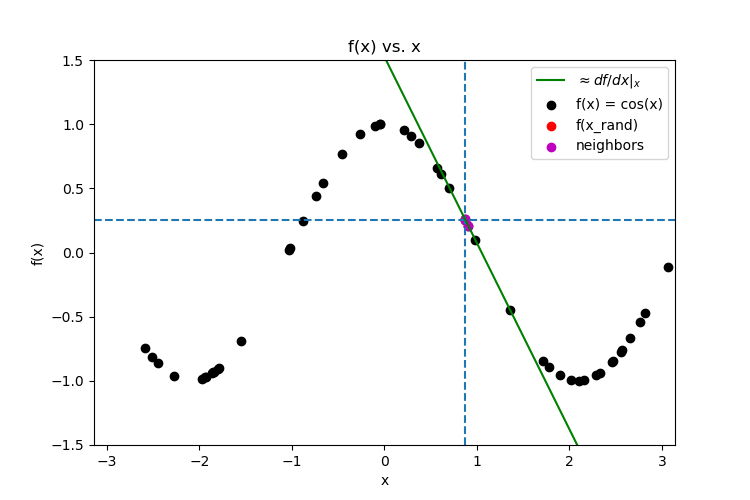

In [152]:
# generate a set of points for the line
x_lin = np.asarray([-np.pi,np.pi])
tangent = f_1*x_lin + f_0
# now to plot it with the neighbors
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 4')
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(-np.pi,np.pi)
axs.set_ylim(-1.5,1.5)
plt.legend()
plt.show()

We can zoom in a bit to see how the tangent line matches up to the true tangent line

<IPython.core.display.Javascript object>


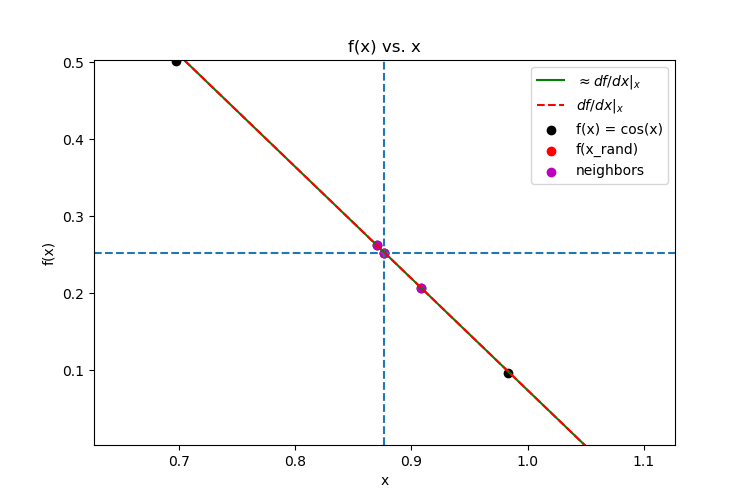

In [153]:
# find the true tangent line
true_d = -1.5*np.sin(1.5*x_rand)
true_0 = -true_d*x_rand + f_rand
true_tangent = true_d*x_lin + true_0

# box volume for zoom
var_e = .25

fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 5')
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.plot(x_lin,true_tangent,color='r',label=r'$df/dx|_{x}$',linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(x_rand-var_e,x_rand+var_e)
axs.set_ylim(f_rand-var_e,f_rand+var_e)
plt.legend()
plt.show()

The error in the tangent line necessarily depends on the approximation parameters $k$ and $n$.  To see how this difference depends on the choice of those parameters, we can survey a few points in the sample space of $(k,n)$ for a particular point.

<IPython.core.display.Javascript object>


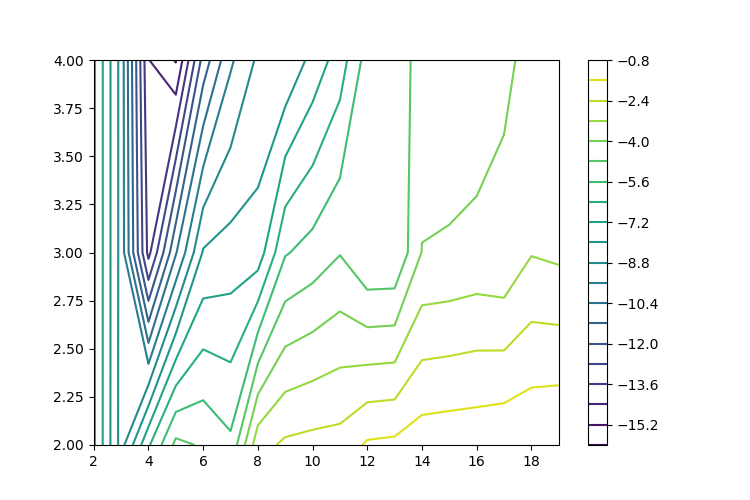

In [154]:
# determine the error in the tangent line according to the choice of k and n
g.query_neighbors(20)
# grab the nearest neighbors to the point x_rand
neighbors = g.get_neighbors(i_rand)
ks = [i for i in range(2,20)]
ns = [i for i in range(2,5)]
error = [[0.0 for i in range(2,20)] for j in range(2,5)]
for i in range(len(ks)):
    for j in range(len(ns)):
        temp_neighbors = [neighbors[l] for l in range(ks[i])]
        temp_x_neighbors = [x[neighbors[l]] for l in range(ks[i])]
        temp_f_neighbors = [f[neighbors[l]] for l in range(ks[i])]
        temp_b_matrix = app.construct_taylor_matrix(g,temp_neighbors,i_rand,ns[j])
        temp_v = Vector("f_vec",temp_f_neighbors)
        temp_f_app = et.dgels(temp_b_matrix,temp_v)
        temp_f_1 = temp_f_app[1]
        error[j][i] = np.log(np.abs(temp_f_1 - true_d))
# now plot the result
X, Y = np.meshgrid(ks,ns)
fig, axs = plt.subplots(figsize=(7.5,5),num='1D MLS example fig. 6')
plt.contour(X,Y,error,20)
plt.colorbar()
plt.show()

## Derivatives at each $x$

In the following interactive plot, you can change the value of $k$ and $n$ as well as the point on the grid that you wish to estimate the derivative of.

<IPython.core.display.Javascript object>


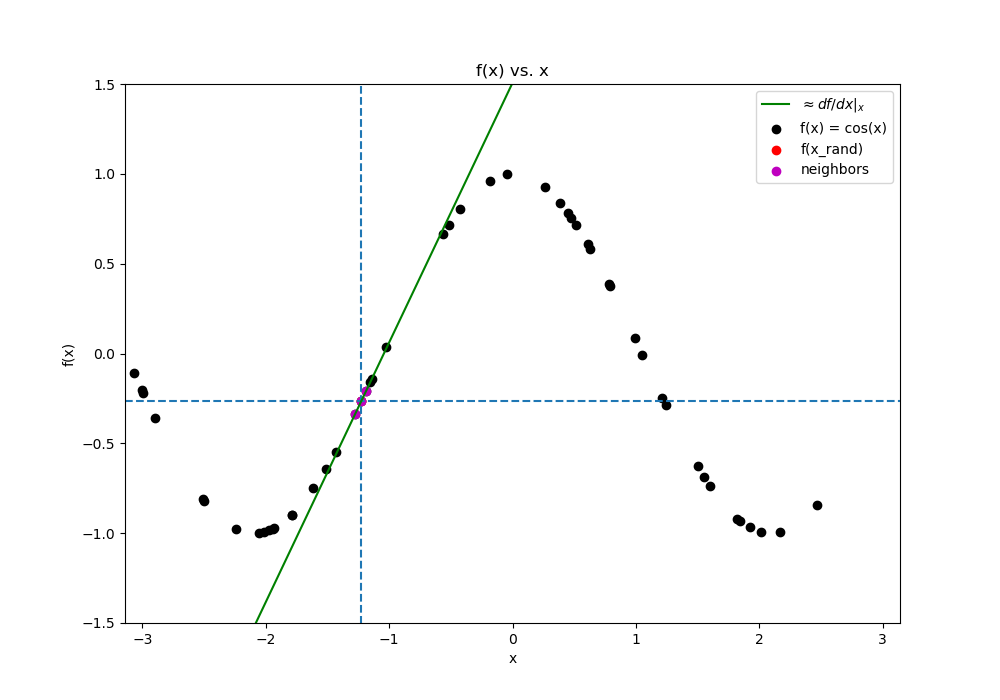

interactive(children=(IntSlider(value=0, description='index', max=49), IntSlider(value=3, description='_k', ma…

In [155]:
# create a random one-dimensional grid
# between -pi and pi.
N = 50
x = np.random.uniform(-np.pi,np.pi,N)
x = np.asarray(sorted(x))
g = UGrid(x)
# generate the function values for f(x) = cos(x)
f = np.cos(1.5*x)
k = 3
n = 2

i_rand = np.random.randint(len(x))
x_rand, f_rand = x[i_rand], f[i_rand]
g.query_neighbors(k)
neighbors = g.get_neighbors(i_rand)
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]
# let's use those neighbors to approximate the derivative
# of f(x) at x_rand.
app = Approximator()
# construct the B matrix for first order in the Taylor expansion
b_matrix = app.construct_taylor_matrix(g,neighbors,i_rand,n)
v = Vector(f_neighbors)
f_app = et.dgelsd(b_matrix,v)
f_0 = -f_app[1]*x_rand + f_rand
f_d = f_app[1]
x_lin = np.linspace(-np.pi,np.pi,50)
tangent = f_d*x_lin + f_0


fig, axs = plt.subplots(figsize=(10,7),num='Derivatives at each x')
line1 = axs.scatter(x,f,color='k',label='f(x) = cos(x)')
line2 = axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
line3 = axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
line4 = axs.axhline(f_rand,linestyle='--')
line5 = axs.axvline(x_rand,linestyle='--')
line6, = axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(-np.pi,np.pi)
axs.set_ylim(-1.5,1.5)
plt.legend()

def update(index = 0, _k = 3, _n = 2):
    g.query_neighbors(_k)
    neighbors = g.get_neighbors(index)
    x_neighbors = [x[i] for i in neighbors]
    f_neighbors = [f[i] for i in neighbors]
    array = [[x_neighbors[i],f_neighbors[i]] for i in range(len(x_neighbors))]
    b_matrix = app.construct_taylor_matrix(g,neighbors,index,_n)
    v = Vector(f_neighbors)
    f_app = et.dgelsd(b_matrix,v)
    f_0 = -f_app[1]*x[index] + f_neighbors[0]
    f_d = f_app[1]
    x_lin = np.linspace(-np.pi,np.pi,50)
    tangent = f_d*x_lin + f_0
    line2.set_offsets((x[index],f[index]))
    line3.set_offsets(np.c_[x_neighbors,f_neighbors])
    line4.set_ydata(f[index])
    line5.set_data(x[index],[-1.5,1.5])
    line6.set_ydata(tangent)
    fig.canvas.draw_idle()

interact(update, index=widgets.IntSlider(min=0, max=N-1, step=1, value=0),
         _k=widgets.IntSlider(min=1, max=N-1, step=1, value=3),
         _n=widgets.IntSlider(min=2, max=10, step=1, value=2));

## Derivatives at arbitrary $x$'s

We can also compute the derivative at any $x$ by interpolating the Taylor expansion using points that are close by.  The following interactive plot allows you to move $x$ around to values that are not part of the grid.

<IPython.core.display.Javascript object>


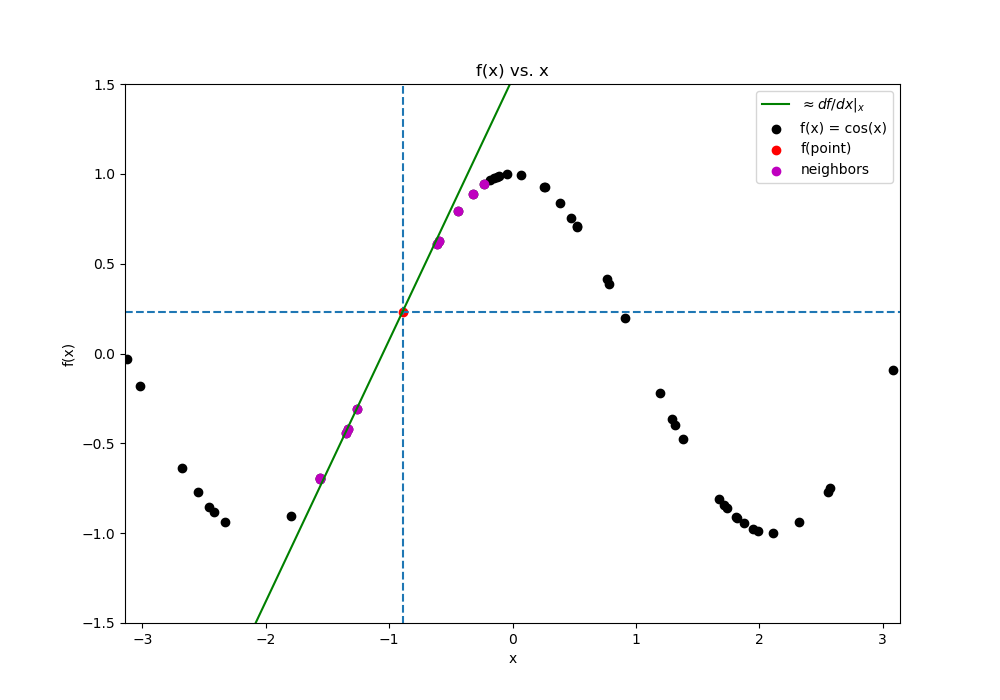

interactive(children=(FloatSlider(value=0.0, description='point', max=3.141592653589793, min=-3.14159265358979…

In [160]:
# create a random one-dimensional grid
# between -pi and pi.
N = 50
x = np.random.uniform(-np.pi,np.pi,N)
x = np.asarray(sorted(x))
g = UGrid(x)
# generate the function values for f(x) = cos(x)
f = np.cos(1.5*x)
k = 3
n = 2

i_rand = np.random.randint(len(x))
x_rand, f_rand = x[i_rand], f[i_rand]
g.query_neighbors(k)
neighbors = g.get_neighbors(i_rand)
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]
# let's use those neighbors to approximate the derivative
# of f(x) at x_rand.
app = Approximator()
# construct the B matrix for first order in the Taylor expansion
b_matrix = app.construct_taylor_matrix(g,neighbors,i_rand,n)
v = Vector(f_neighbors)
f_app = et.dgelsd(b_matrix,v)
f_0 = -f_app[1]*x_rand + f_rand
f_d = f_app[1]
x_lin = np.linspace(-np.pi,np.pi,50)
tangent = f_d*x_lin + f_0


fig, axs = plt.subplots(figsize=(10,7))
line1 = axs.scatter(x,f,color='k',label='f(x) = cos(x)')
line2 = axs.scatter(x_rand,f_rand,color='r',label='f(point)')
line3 = axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
line4 = axs.axhline(f_rand,linestyle='--')
line5 = axs.axvline(x_rand,linestyle='--')
line6, = axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
axs.set_xlim(-np.pi,np.pi)
axs.set_ylim(-1.5,1.5)
plt.legend()

def update(point = 0.0, _k = 3, _n = 2):
    neighbors = g.query_neighbors([point],_k)
    x_neighbors = [x[i] for i in neighbors]
    f_neighbors = [f[i] for i in neighbors]
    array = [[x_neighbors[i],f_neighbors[i]] for i in range(len(x_neighbors))]
    b_matrix = app.construct_taylor_matrix(g,neighbors,[point],_n)
    v = Vector(f_neighbors)
    f_app = et.dgelsd(b_matrix,v)
    f_0 = -f_app[1]*point + f_app[0]
    f_d = f_app[1]
    x_lin = np.linspace(-np.pi,np.pi,50)
    tangent = f_d*x_lin + f_0
    line2.set_offsets((point,f_app[0]))
    line3.set_offsets(np.c_[x_neighbors,f_neighbors])
    line4.set_ydata(f_app[0])
    line5.set_data(point,[-1.5,1.5])
    line6.set_ydata(tangent)
    fig.canvas.draw_idle()

interact(update, point=widgets.FloatSlider(min=-np.pi, max=np.pi, step=.05, value=0),
         _k=widgets.IntSlider(min=1, max=N-1, step=1, value=3),
         _n=widgets.IntSlider(min=2, max=10, step=1, value=2));

## Scalar fields and higher derivatives

The $n$th-derivative of a function can be computed in a single call of the ScalarField class.  The ScalarField class implements several other useful methods which are discussed in detail in a different notebook.  In order to create a scalar field, simply call the constructor with a grid and a set of function values over the grid.  You can pass in a logger instance as well.

In [169]:
# create a random one-dimensional grid
# between -pi and pi.
N = 1000
x = np.random.uniform(-np.pi,np.pi,N)
x = np.asarray(sorted(x))
g = UGrid(x)
# generate the function values for f(x) = cos(x)
f = np.cos(1.5*x)

# create a scalar field using g and f
s = ScalarField(g,f,g.get_logger())

print(s)

++++++++++++++++++++++++++++++++++++++++++++++++++++
<etraj.ScalarField ref at 0x563c53ac2f30>
---------------------------------------------------
<ET::ScalarField<double&> object at 0x7ffc89ddad38>
---------------------------------------------------
   name: 'default'
    dim: 1
      N: 1000
---------------------------------------------------
UGrid 'default' at: 0x563c539b7540,
            ref at: 0x563c53ac2f90
Approximator at: 0x563c539a09c0,
         ref at: 0x563c53ac2fa0
Logger at: 0x563c539b7540,
   ref at: 0x563c53ac2fc0
++++++++++++++++++++++++++++++++++++++++++++++++++++


Scalar fields come with their own approximator, so there is no need to create one.  One can adjust the settings of the fields approximator by calling get_approximator() and using the standard setters and getters from the Approximator class.

In [170]:
# set the fields approximator to use a k value of 10
k = 10
s.get_approximator().set_k(k)

To get the derivative of the field using the default settings from the fields approximator instance, simply use the 'derivative' function.  The derivative function is overloaded so that various sets of arguments can be passed in.  

In [171]:
# get the first derivative in the 0th direction
df_dx = s.derivative(0,1)

Let's plot the values found for the derivative of the entire function

<IPython.core.display.Javascript object>


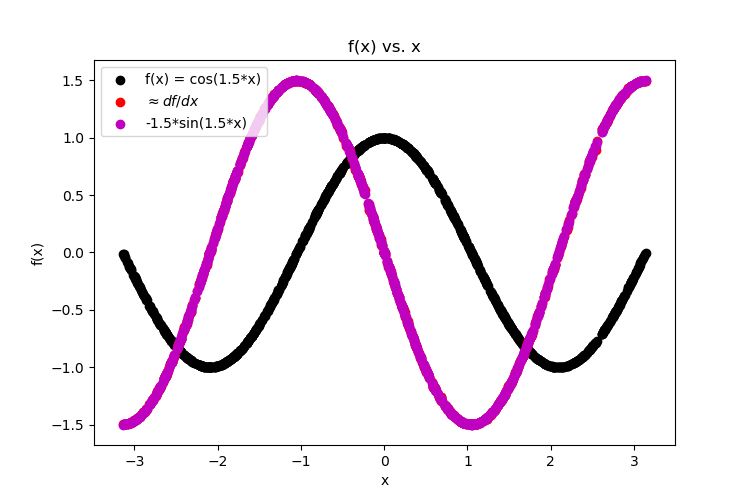

In [173]:
# determine the true derivative at each point
df_dx_true = -1.5*np.sin(1.5*x)

# plot the estimated derivative and the true derivative
fig, axs = plt.subplots(figsize=(7.5,5),num='Scalarfield derivative')
axs.scatter(x,f,color='k',label='f(x) = cos(1.5*x)')
axs.scatter(x,df_dx,color='r',label=r'$\approx df/dx$')
axs.scatter(x,df_dx_true,color='m',label='-1.5*sin(1.5*x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

As you can see from the plot, there is practically no difference between the purple and red curves.  We can also compute higher derivatives.

<IPython.core.display.Javascript object>


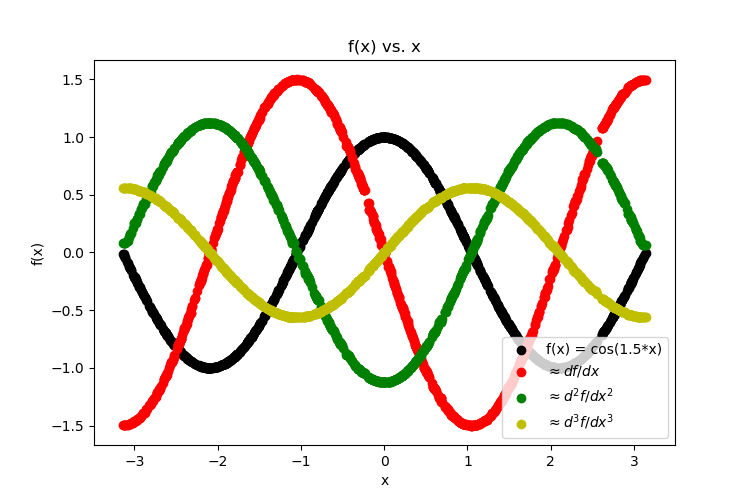

In [175]:
# compute the second and third derivative
d2f_dx2= s.derivative(0,2)
d3f_dx3 = s.derivative(0,3)

# plot the results
fig, axs = plt.subplots(figsize=(7.5,5))
axs.scatter(x,f,color='k',label='f(x) = cos(1.5*x)')
axs.scatter(x,df_dx,color='r',label=r'$\approx df/dx$')
axs.scatter(x,d2f_dx2,color='g',label=r'$\approx d^2f/dx^2$')
axs.scatter(x,d3f_dx3,color='y',label=r'$\approx d^3f/dx^3$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()